## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability



In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
#read in the dataset and view the top few rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
#how many rows are in the dataset
df.shape[0]

294478

In [4]:
#how many unique users
df.user_id.nunique()

290584

In [5]:
# proportion of users converted.
users_conv = df.query('converted == "1"').user_id.nunique()/df.user_id.nunique()
users_conv

0.12104245244060237

In [7]:
# number of times the new_page and treatment don't match
nomatch_df = df.query('(group == "treatment" and landing_page != "new_page") or (group == "control" and landing_page == "new_page")')
nomatch_df.shape[0]


3893

In [6]:
#check if any of the rows have missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
# df where 'treatment' and 'new_page' match, and 'control' and 'old_page' match
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
#number of unique user_ids in df2
df2.user_id.nunique()

290584

In [11]:
# list duplicated user_id
df2[df2.duplicated(['user_id'])]


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
#row information for duplicate user_id
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
#drop duplicate row
df2.drop_duplicates(['user_id'], keep=False, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
#result of 0 means there are no duplicate user_ids
sum(df2.duplicated(['user_id']))

0

In [15]:
#new number of rows and columns in df2
df2.shape

(290583, 5)

In [16]:
#probability of an individual converting regardless of the page they receive
df2.converted.mean()

0.11959749882133504

In [17]:
# to validate answer above
df2.query('converted == 1').count()/df2.shape[0]

user_id         0.119597
timestamp       0.119597
group           0.119597
landing_page    0.119597
converted       0.119597
dtype: float64

In [18]:
#probability of a user in control group to convert
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

In [19]:
#probability of a user in treatment group to convert
df2.query('group == "treatment"')['converted'].mean()

0.11880888313869065

In [20]:
#probability of a user to receive a new page
df2.query('landing_page == "new_page"').count()/df2.shape[0]

user_id         0.50006
timestamp       0.50006
group           0.50006
landing_page    0.50006
converted       0.50006
dtype: float64

Consider the results, is there sufficient evidence to conclude that the new treatment page leads to more conversions?

**There is no sufficient evidence that the new treatment page leads to more conversions. The conversion rates were almost the same. The 'control' group had a 12.03% probability of conversion, and the 'treatment' group had a 11.88% probability of conversion.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**NULL HYPOTHESIS is H0: Pnew - Pold <= 0**

**ALTERNATIVE HYPOTHESIS is H1: Pnew - Pold > 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
# conversion rate for  𝑝𝑛𝑒𝑤  under the null
Pnew = df2.query('converted == 1').user_id.nunique()/df2.user_id.nunique()
Pnew

0.11959749882133504

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
# conversion rate for  𝑝old  under the null
Pold = df2.query('converted == 1').user_id.nunique()/df2.user_id.nunique()
Pold

0.11959749882133504

In [23]:
# number of individuals in the treatment group
Nnew = df2.query('group == "treatment"').user_id.nunique()
Nnew

145309

**NOTE: 145309 is the number of individuals after dropping duplicate user_id.  Accepted answer below is 145310, which is the number of records with the duplicate.**

In [24]:
# number of individuals in the control group
Nold = df2.query('group == "control"').user_id.nunique()
Nold

145274

In [25]:
#assigns Pnew conversion rate to '1'
new_page_converted = np.random.choice([0,1], Nnew, p=(1-Pnew,Pnew))
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
#assigns Pold conversion rate to '1'
old_page_converted = np.random.choice([0,1], Nold, p=(1-Pold, Pold))
old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

In [27]:
#conversion rate of simulated values for new_page
new_page_converted.mean()

0.12004074076622921

In [28]:
#conversion rate of simulated values for old_page
old_page_converted.mean()

0.11993199058331154

In [29]:
#difference in conversion rates of simulated values
conv_diff = new_page_converted.mean() - old_page_converted.mean()
conv_diff

0.0001087501829176718

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
#simulate 10,000 values of the difference of Pnew-Pold
new_samples = np.random.binomial(Nnew, Pnew, 10000)/Nnew
old_samples = np.random.binomial(Nold, Pold, 10000)/Nold
p_diffs = new_samples - old_samples

In [31]:
#store the values in a new array
p_diffs = np.array(p_diffs)

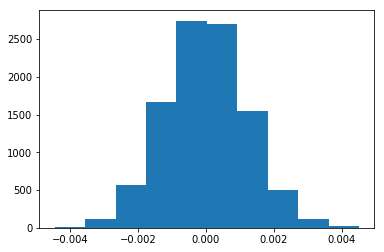

In [32]:
#plot a histogram of the p_diffs 
plt.hist(p_diffs);

In [33]:
#create distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

In [34]:
#calculate observed difference in converted rates from pages using df2 
new_page_df = df2.query('landing_page == "new_page"')
old_page_df = df2.query('landing_page == "old_page"')

In [35]:
#conversion rate when landing on new_page
new_page_ctr = new_page_df['converted'].mean()
new_page_ctr

0.11880888313869065

In [36]:
#conversion rate when landing on old_page
old_page_ctr = old_page_df['converted'].mean()
old_page_ctr

0.1203863045004612

In [37]:
#calculate obeserved difference in conversion rates
obs_diff = new_page_ctr - old_page_ctr
obs_diff

-0.0015774213617705535

In [38]:
#compute p-value
(null_vals > obs_diff).mean()

0.9098

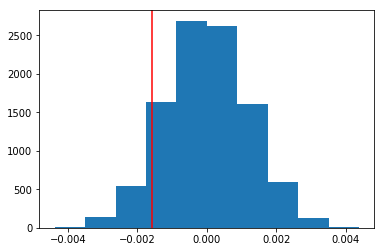

In [39]:
#plot histogram of the null hypothesis distribution with the observed difference
plt.hist(null_vals);
plt.axvline(obs_diff, c='red');

**My observed difference is -0.0016 (where the red line falls). To simulate from the null, I created a normal distribution centered at zero, with the same standard deviation as the sampling distribution.  The proportion of values in the null distribution (null_vals) that were greater than the observed difference (obs_diff) were 0.9098 (p-value). With a large p-value, it means the  difference doesn't appear to be significant in favor of the alternative.** 

**The p-value of 0.9098 is greater than the alpha (Type I error of 0.05). Based on these results, I fail to reject the null, and should keep the old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [40]:
#using a built-in to achieve similar results
import statsmodels.api as sm

#calculate the number of conversions for each page
convert_old = df2.query('landing_page == "old_page" and converted ==1').user_id.nunique()
convert_new = df2.query('landing_page == "new_page" and converted ==1').user_id.nunique()

#calculate the number of unique users who received each page
n_old = df2.query('landing_page == "old_page"').user_id.nunique()
n_new = df2.query('landing_page == "new_page"').user_id.nunique()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [41]:
#use stats.proportion_ztest to compute the test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old], alternative = 'larger')
z_score, p_value

(-1.3102408579271012, 0.9049428161159749)

**SUMMARY**

**The z-score is -1.31, so the confidence level is lower than 95%, or higher than Type I error rate of 5% (alpha).The p-value of 0.905 is close to part j. p-value of 0.9098, and is still greater than the alpha of 0.05.**

**Therefore, the conclusion in part k. remains - I fail to reject the null, and stay with the old page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**I should use Logistic Regression to predict from 2 different outcomes.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. 

In [42]:
# create dummy variables for group and landin_page values
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2['intercept'] = 1

df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


In [43]:
#instantiate the regression model on the 2 columns created above
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

#fit the model using the two columns created to predict whether or not 
#an individual converts
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366119
         Iterations 6


In [44]:
#summary of the regression model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Apr 2019   Pseudo R-squ.:               8.068e-06
Time:                        05:22:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1901
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.310      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with the ab_page is 0.190. The p-values calculated from Part II statmodels.proportions_ztest are 0.905 and 0.9098. It differs from Part II, because Part III is a two-tailed test. The null hypothesis in Part II assumes null <= 0.  The null hypothesis of the regression model assumes null = 0, making it a two-tailed test. Therefore, 0.190 has to be divided by 2 and subtracted from 1: 1-(0.190/2) = 0.905 (same as part II p-value).**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It's a good idea to consider other factors to add into the regression model because it makes us look closer at how the factors influence each other. These might provide additonal insights that may not be visible initially. However, this also introduces more complexity and possible confusions than necessary.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

Does it appear that country had an impact on conversion?  

In [45]:
#read in countries.csv dataset
df_ctry = pd.read_csv('countries.csv')
df_ctry.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [47]:
#creat a new df by joining country df to df2
df3 = df2.join(df_ctry.set_index('user_id'), on='user_id' )
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [49]:
#view unique values in 'country' column
df3['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [61]:
#create dummy variables for categorical values in 'country'
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,US,UK,new_page,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,1,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,1,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,1,0,0,0


In [62]:
#compare conversion rates by country
df3.groupby('country').mean()['converted']

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

In [63]:
#drop CA column
df3 = df3.drop('CA', axis=1)
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,US,UK,new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,1,0,0


In [65]:
#instantiate and fit a regression model using the new columns 
#to predict whether a user will convert or not
df3['intercept'] = 1

logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'US']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            3
Date:                Mon, 29 Apr 2019   Pseudo R-squ.:               2.322e-05
Time:                        06:07:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1761
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.306      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.129      -0.012       0.093
==============================================================================
"""

In [67]:
#exponentiate the results
np.exp(result.params)

intercept    0.131331
ab_page      0.985175
UK           1.051944
US           1.041605
dtype: float64

In [70]:
#validating exponentiated results 
np.exp(-0.0149), np.exp(0.0506), np.exp(0.048)

(0.9852104557227469, 1.0519020483004984, 1.0491706553244706)

In [72]:
#getting the reciprocal of returned values less than 1 (ab_page)
1/np.exp(-0.0149)

1.0150115583846535

**SUMMARY ON CONVERSION**

1. The p-values of the new page (ab_page), US and UK are all greater than 0.05, and are not statistically significant in predicting conversion, as shown in the statements below.

2. Conversion is 1.04 times as likely in CA as in the US if a user landed on a new page, holding all other variables constant.

3. Conversion is 1.05 times as likely in CA as in the UK if a user landed on a new page, holding all other variables constant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [69]:
#proportion of new_page received per country
df3.groupby('country').mean()['ab_page']

country
CA    0.503552
UK    0.498247
US    0.500457
Name: ab_page, dtype: float64

In [74]:
#factors by country
df3['UK_ab_page'] = df3['ab_page'] * df3['UK']
df3['US_ab_page'] = df3['ab_page'] * df3['US']

In [84]:
#instantiate and fit a regression model using the new columns 
#to predict whether a user will convert or not
logit_mod2 = sm.Logit(df3['converted'], df3[['intercept','UK_ab_page', 'US_ab_page', 'UK','US']])
result2 = logit_mod2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            4
Date:                Mon, 29 Apr 2019   Pseudo R-squ.:               2.690e-05
Time:                        08:01:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2207
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK_ab_page     0.0108      0.023      0.475      0.635      -0.034       0.056
US_ab_page    -0.0206      0.014     -1.504      0.132      -0.047       0.006
UK             0.0453      0.031      1.481      0.139      -0.015       0.105
US             0.0511      0.028      1.841      0.066      -0.003       0.105
==============================================================================
"""

In [85]:
#exponentiate the results
np.exp(result2.params)

intercept     0.130350
UK_ab_page    1.010893
US_ab_page    0.979657
UK            1.046352
US            1.052380
dtype: float64

**SUMMARY**

1. Users in each group (control and treatment) in all countries received an even proportion of corresponding pages to land on.

2. Z-scores are all higher than 0.05 (5%), which shows confidence levels are not high (>95%) to predict conversion. 

3. P-values suggest that all the variables are not statistically significant to predict conversion.

4. Looking at the interaction between page and country does not produce significant effects on conversion.

In [91]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_AB_test_results_LHSaez.ipynb'])

0